In [12]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from pydantic import BaseModel, Field
import os

In [13]:
key = os.getenv("GOOGLE_API_KEY")
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", api_key=key)

In [14]:
class QueryType(BaseModel):
    query_type: Literal["recent_news", "detailed_report", "unsure"] = Field(description="Categorises user's query")

In [15]:
structured_model1 = llm.with_structured_output(QueryType)

In [16]:
class ConditionState(TypedDict):
    user_query: str
    query_type: Literal["recent_news", "detailed_report", "unsure"]
    fetched_news: str
    report_from_llm: str
    report_from_news: str
    unsure: str

In [27]:
def categorise_query(state:ConditionState):
    prompt = f"Categorise the user's query: {state['user_query']}"
    query_type = structured_model1.invoke(prompt).query_type
    return {"query_type": query_type}

def check_category(state: ConditionState) -> Literal["recent_news", "detailed_report", "unsure"]:
    if state['query_type'] == "recent_news":
        return "recent_news"
    elif state['query_type'] == "detailed_report":
        return "detailed_report"
    else:
        return "unsure"
    
def recent_news(state:ConditionState):
    return {"fetched_news": "Jeffrey Epstein shot himself"}

def from_news(state:ConditionState):
    prompt = f"From the fetched news which is: \n {state['fetched_news']}\n generate a report"   
    report_from_news = llm.invoke(prompt).content
    return {"report_from_news": report_from_news}

def detailed_report(state:ConditionState):
    prompt = f"Using the topic provided by the user in this user query:\n {state['user_query']}\n Generate a detailed report on it."
    report_from_llm = llm.invoke(prompt).content
    return {"report_from_llm": report_from_llm}

def unsure(state:ConditionState):
    prompt = f"Apologise to the user for not able to able their query."
    unsure_response = llm.invoke(prompt).content
    return {"unsure": unsure_response}



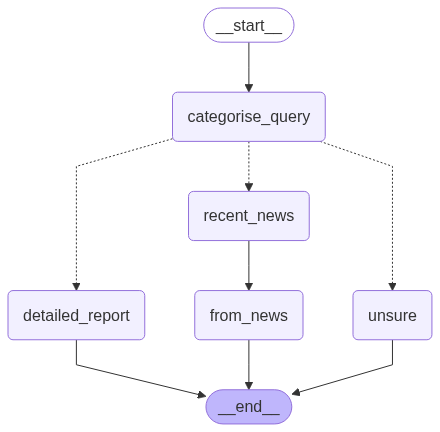

In [29]:
graph_builder = StateGraph(ConditionState)

graph_builder.add_node("categorise_query", categorise_query)
graph_builder.add_node("recent_news", recent_news)
graph_builder.add_node("from_news", from_news)
graph_builder.add_node("detailed_report", detailed_report)
graph_builder.add_node("unsure", unsure)


graph_builder.add_edge(START, "categorise_query")
graph_builder.add_conditional_edges("categorise_query", check_category)
graph_builder.add_edge("recent_news", "from_news")
graph_builder.add_edge("from_news", END)
graph_builder.add_edge("detailed_report", END)
graph_builder.add_edge("unsure", END)

workflow = graph_builder.compile()
workflow

In [30]:
initial_state = {"user_query": "unga boonga?"}
workflow.invoke(initial_state)

{'user_query': 'unga boonga?',
 'query_type': 'unsure',
 'unsure': 'Okay, here are a few options for apologizing, choose the one that best fits the situation:\n\n**Option 1 (General & Concise):**\n\n> I apologize, but I\'m unable to assist with your query at this time. Is there anything else I can help you with?\n\n**Option 2 (Slightly more detailed, implying a limitation):**\n\n> I\'m sorry, but I wasn\'t able to process or respond to your request. Could you please rephrase it or provide more details?\n\n**Option 3 (Acknowledging a potential lack of information/understanding):**\n\n> My apologies, but I\'m currently unable to address your query. I may not have enough information or understand the request fully.\n\n**Option 4 (If it\'s about a specific type of query you can\'t handle):**\n\n> I apologize, but I\'m not equipped to handle that type of query at the moment.\n\n---\n\n**When you use it, replace "their query" with "your query" as you\'ll be addressing the user directly.**'}